Selecciona una opción:
1. Entrenamiento completo
2. Solo probar entorno
=== ENTRENAMIENTO KUKA PARA VOLTEAR VASO ===
Creando entorno Kuka...
Robot Kuka cargado con 7 articulaciones
  Joint 0: lbr_iiwa_joint_1 - Límites: (-2.97, 2.97)
  Joint 1: lbr_iiwa_joint_2 - Límites: (-2.09, 2.09)
  Joint 2: lbr_iiwa_joint_3 - Límites: (-2.97, 2.97)
  Joint 3: lbr_iiwa_joint_4 - Límites: (-2.09, 2.09)
  Joint 4: lbr_iiwa_joint_5 - Límites: (-2.97, 2.97)
  Joint 5: lbr_iiwa_joint_6 - Límites: (-2.09, 2.09)
  Joint 6: lbr_iiwa_joint_7 - Límites: (-3.05, 3.05)
Posición inicial del efector: (0.2539530107463904, 0.13874411046464585, 0.9968655842147205)
Posición del vaso: [0.6, 0.3, 0.075]
Distancia inicial: 0.998m
Vaso dentro del workspace: ✅
Entorno creado exitosamente!
Inicializando agente PPO...
Agente inicializado!
Iniciando entrenamiento... (Presiona Ctrl+C para parar)
Robot Kuka cargado con 7 articulaciones
  Joint 0: lbr_iiwa_joint_1 - Límites: (-2.97, 2.97)
  Joint 1: lbr_iiwa_joint_2 - Límites

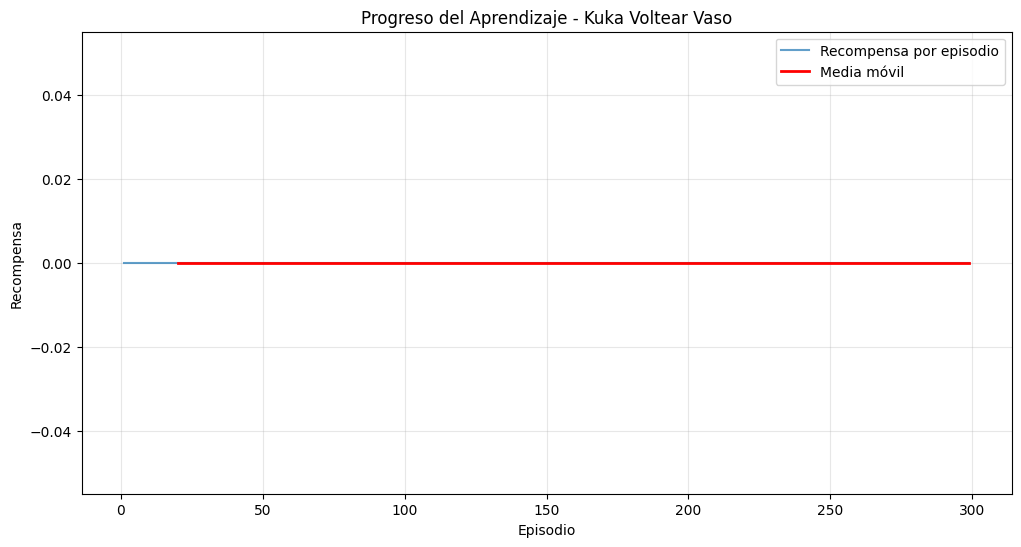


=== DEMOSTRACIÓN FINAL ===
Robot Kuka cargado con 7 articulaciones
  Joint 0: lbr_iiwa_joint_1 - Límites: (-2.97, 2.97)
  Joint 1: lbr_iiwa_joint_2 - Límites: (-2.09, 2.09)
  Joint 2: lbr_iiwa_joint_3 - Límites: (-2.97, 2.97)
  Joint 3: lbr_iiwa_joint_4 - Límites: (-2.09, 2.09)
  Joint 4: lbr_iiwa_joint_5 - Límites: (-2.97, 2.97)
  Joint 5: lbr_iiwa_joint_6 - Límites: (-2.09, 2.09)
  Joint 6: lbr_iiwa_joint_7 - Límites: (-3.05, 3.05)
Posición inicial del efector: (0.2539530107463904, 0.13874411046464585, 0.9968655842147205)
Posición del vaso: [0.6, 0.3, 0.075]
Distancia inicial: 0.998m
Vaso dentro del workspace: ✅

Demostración 1/3
Error en demostración final: Not connected to physics server.

Programa terminado.


In [3]:
import pybullet as p
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.optim as optim
import time
import gym
from gym import spaces

# Parámetros globales
WORKSPACE_RADIUS = 1.0
VASO_HEIGHT = 0.15
VASO_RADIUS = 0.04
VASO_FIXED_POS = [0.6, 0.3, VASO_HEIGHT/2]  # Posición fija del vaso

class KukaFlipEnv(gym.Env):
    def __init__(self, gui=False):
        super(KukaFlipEnv, self).__init__()
        self.gui = gui
        self.max_steps = 500  # Más pasos para aprender
        self.step_count = 0
        self.best_distance = float('inf')
        self.success_count = 0

        # Espacios de acción y observación
        # 7 articulaciones del Kuka (controlamos directamente las posiciones de joints)
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(7,), dtype=np.float32)
        
        # Observación: 7 joint_angles + 3 efector_pos + 3 vaso_pos + 4 vaso_ori = 17
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(17,), dtype=np.float32)

        self._connect()
        self.reset()

    def _connect(self):
        """Conectar a PyBullet de forma segura"""
        # Primero intentar desconectar cualquier conexión existente
        try:
            p.disconnect()
        except:
            pass
        
        # Pequeña pausa para asegurar desconexión completa
        time.sleep(0.1)
        
        if self.gui:
            p.connect(p.GUI)
            # Configurar cámara para mejor visualización
            p.resetDebugVisualizerCamera(
                cameraDistance=2.0,
                cameraYaw=45,
                cameraPitch=-30,
                cameraTargetPosition=[0.5, 0.2, 0.3]
            )
            p.configureDebugVisualizer(p.COV_ENABLE_GUI, 1)
            p.configureDebugVisualizer(p.COV_ENABLE_SHADOWS, 1)
        else:
            p.connect(p.DIRECT)
        
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.8)
        p.setTimeStep(1./240.)

    def reset(self):
        """Reiniciar entorno"""
        p.resetSimulation()
        self.step_count = 0
        self.best_distance = float('inf')
        p.setGravity(0, 0, -9.8)
        
        # Cargar plano
        p.loadURDF("plane.urdf")

        # Cargar robot Kuka con base fija
        self.robot_id = p.loadURDF("kuka_iiwa/model.urdf", useFixedBase=True)
        
        # Obtener información del robot
        self.num_joints = p.getNumJoints(self.robot_id)
        print(f"Robot Kuka cargado con {self.num_joints} articulaciones")
        
        # Obtener límites de articulaciones
        self.joint_limits = []
        for i in range(self.num_joints):
            joint_info = p.getJointInfo(self.robot_id, i)
            if joint_info[2] == p.JOINT_REVOLUTE:  # Solo articulaciones revolutas
                lower_limit = joint_info[8] if joint_info[8] > -1000 else -np.pi
                upper_limit = joint_info[9] if joint_info[9] < 1000 else np.pi
                self.joint_limits.append((lower_limit, upper_limit))
                print(f"  Joint {i}: {joint_info[1].decode('utf-8')} - Límites: ({lower_limit:.2f}, {upper_limit:.2f})")
            else:
                self.joint_limits.append((-np.pi, np.pi))

        # Crear vaso en posición fija
        self.cup_pos = VASO_FIXED_POS
        self._create_vaso()
        
        # Posición inicial del robot (extendido hacia el vaso)
        self._set_initial_position()
        
        # Esperar estabilización
        for _ in range(50):
            p.stepSimulation()

        # Información inicial
        self._print_initial_info()
        
        return self._get_obs()

    def _create_vaso(self):
        """Crear vaso personalizado"""
        # Crear vaso como cilindro
        vaso_collision = p.createCollisionShape(p.GEOM_CYLINDER, 
                                               radius=VASO_RADIUS, 
                                               height=VASO_HEIGHT)
        vaso_visual = p.createVisualShape(p.GEOM_CYLINDER, 
                                        radius=VASO_RADIUS, 
                                        length=VASO_HEIGHT,
                                        rgbaColor=[0.2, 0.8, 0.2, 1])  # Verde brillante
        
        self.cup_id = p.createMultiBody(
            baseMass=0.1,
            baseCollisionShapeIndex=vaso_collision,
            baseVisualShapeIndex=vaso_visual,
            basePosition=self.cup_pos
        )
        
        # Configurar propiedades físicas
        p.changeDynamics(self.cup_id, -1, 
                        lateralFriction=0.7, 
                        restitution=0.3,
                        rollingFriction=0.1)

    def _set_initial_position(self):
        """Establecer posición inicial del robot"""
        # Posición inicial que apunte hacia el vaso
        initial_joint_positions = [
            0.5,     # Joint 0: girar hacia el vaso
            -0.3,    # Joint 1: inclinar hombro
            0.0,     # Joint 2: neutral
            -1.2,    # Joint 3: doblar codo
            0.0,     # Joint 4: neutral
            0.8,     # Joint 5: ajustar muñeca
            0.0      # Joint 6: neutral
        ]
        
        # Aplicar límites
        for i in range(min(7, len(initial_joint_positions))):
            if i < len(self.joint_limits):
                lower, upper = self.joint_limits[i]
                initial_joint_positions[i] = np.clip(initial_joint_positions[i], lower, upper)
        
        # Establecer posiciones
        for i in range(min(7, len(initial_joint_positions))):
            p.resetJointState(self.robot_id, i, initial_joint_positions[i])

    def _print_initial_info(self):
        """Imprimir información inicial"""
        ee_pos = self._get_end_effector_position()
        distance = np.linalg.norm(np.array(ee_pos) - np.array(self.cup_pos))
        
        print(f"Posición inicial del efector: {ee_pos}")
        print(f"Posición del vaso: {self.cup_pos}")
        print(f"Distancia inicial: {distance:.3f}m")
        print(f"Vaso dentro del workspace: {'✅' if np.linalg.norm(self.cup_pos[:2]) <= WORKSPACE_RADIUS else '❌'}")

    def _get_end_effector_position(self):
        """Obtener posición del efector final"""
        # El efector final del Kuka está en el link 6 (última articulación)
        ee_state = p.getLinkState(self.robot_id, 6)
        return ee_state[0]  # Posición

    def _get_obs(self):
        """Obtener observación actual"""
        # Estados de las articulaciones (7)
        joint_states = []
        for i in range(7):
            joint_state = p.getJointState(self.robot_id, i)
            joint_states.append(joint_state[0])  # Posición del joint
        
        # Posición del efector final (3)
        ee_pos = self._get_end_effector_position()
        
        # Posición y orientación del vaso (3 + 4)
        cup_pos, cup_ori = p.getBasePositionAndOrientation(self.cup_id)
        
        # Combinar todas las observaciones
        obs = np.array(joint_states + list(ee_pos) + list(cup_pos) + list(cup_ori), dtype=np.float32)
        return obs

    def step(self, action):
        """Ejecutar acción"""
        self.step_count += 1
        
        # Obtener posiciones actuales de joints
        current_positions = []
        for i in range(7):
            joint_state = p.getJointState(self.robot_id, i)
            current_positions.append(joint_state[0])
        
        # Aplicar acción como cambio incremental
        new_positions = []
        for i in range(7):
            new_pos = current_positions[i] + action[i]
            
            # Aplicar límites de articulación
            if i < len(self.joint_limits):
                lower, upper = self.joint_limits[i]
                new_pos = np.clip(new_pos, lower, upper)
            
            new_positions.append(new_pos)
        
        # Controlar el robot
        for i in range(7):
            p.setJointMotorControl2(
                self.robot_id, i, 
                p.POSITION_CONTROL, 
                targetPosition=new_positions[i], 
                force=150.0,
                positionGain=0.5,
                velocityGain=0.1
            )

        # Simular física
        for _ in range(5):
            p.stepSimulation()
            if self.gui:
                time.sleep(1. / 240.)

        # Obtener nueva observación
        obs = self._get_obs()
        
        # Calcular recompensa
        reward = self._calculate_reward()
        
        # Verificar si terminó
        done = self._check_done()
        
        # Mostrar información de debug visual
        if self.gui:
            self._add_debug_info()

        return obs, reward, done, {}

    def _calculate_reward(self):
        """Calcular recompensa"""
        # Posición del efector y del vaso
        ee_pos = self._get_end_effector_position()
        cup_pos, cup_ori = p.getBasePositionAndOrientation(self.cup_id)
        
        # Distancia al vaso
        distance = np.linalg.norm(np.array(ee_pos) - np.array(cup_pos))
        
        # Recompensa base por distancia
        distance_reward = -distance * 10.0
        
        # Bonificación por progreso
        progress_reward = 0
        if distance < self.best_distance:
            progress_reward = (self.best_distance - distance) * 50
            self.best_distance = distance
        
        # Verificar si el vaso está volteado
        euler_angles = p.getEulerFromQuaternion(cup_ori)
        tilt_angle = max(abs(euler_angles[0]), abs(euler_angles[1]))
        
        # Recompensas por proximidad y éxito
        if tilt_angle > np.pi/6:  # Vaso volteado más de 30°
            return 1000.0 + distance_reward
        elif distance < 0.05:  # Muy cerca
            return 200.0 + distance_reward + progress_reward
        elif distance < 0.1:   # Cerca
            return 100.0 + distance_reward + progress_reward
        elif distance < 0.2:   # Moderadamente cerca
            return 50.0 + distance_reward + progress_reward
        else:
            return distance_reward + progress_reward

    def _check_done(self):
        """Verificar condiciones de terminación"""
        # Límite de tiempo
        if self.step_count >= self.max_steps:
            return True
        
        # Verificar éxito (vaso volteado)
        cup_pos, cup_ori = p.getBasePositionAndOrientation(self.cup_id)
        euler_angles = p.getEulerFromQuaternion(cup_ori)
        tilt_angle = max(abs(euler_angles[0]), abs(euler_angles[1]))
        
        if tilt_angle > np.pi/6:  # Éxito
            self.success_count += 1
            return True
        
        # Verificar si el vaso cayó
        if cup_pos[2] < 0.02:
            return True
        
        return False

    def _add_debug_info(self):
        """Añadir información visual de debug"""
        try:
            # Línea del efector al vaso
            ee_pos = self._get_end_effector_position()
            cup_pos, _ = p.getBasePositionAndOrientation(self.cup_id)
            
            p.addUserDebugLine(ee_pos, cup_pos, [1, 0, 0], lineWidth=3, lifeTime=0.1)
            
            # Círculo del workspace
            circle_points = []
            for angle in np.linspace(0, 2*np.pi, 32):
                x = WORKSPACE_RADIUS * np.cos(angle)
                y = WORKSPACE_RADIUS * np.sin(angle)
                circle_points.append([x, y, 0.01])
            
            for i in range(len(circle_points)-1):
                p.addUserDebugLine(circle_points[i], circle_points[i+1], [0, 1, 1], lineWidth=2, lifeTime=0.1)
            p.addUserDebugLine(circle_points[-1], circle_points[0], [0, 1, 1], lineWidth=2, lifeTime=0.1)
            
            # Información de distancia - SIN textColor
            distance = np.linalg.norm(np.array(ee_pos) - np.array(cup_pos))
            p.addUserDebugText(f"Distancia: {distance:.3f}m", 
                              [cup_pos[0], cup_pos[1], cup_pos[2] + 0.2],
                              textSize=1.0, lifeTime=0.1)
        except Exception as e:
            # Ignorar errores de debug para no interrumpir el entrenamiento
            pass

    def close(self):
        """Cerrar entorno"""
        p.disconnect()

# Red neuronal adaptada para el Kuka (7 articulaciones)
class KukaPolicyNetwork(nn.Module):
    def __init__(self, input_dim=17, action_dim=7, hidden_size=256):
        super(KukaPolicyNetwork, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU()
        )
        
        self.mean_layer = nn.Linear(hidden_size//2, action_dim)
        self.std_layer = nn.Linear(hidden_size//2, action_dim)
        
    def forward(self, x):
        features = self.network(x)
        mean = torch.tanh(self.mean_layer(features)) * 0.1  # Acciones pequeñas
        std = torch.nn.functional.softplus(self.std_layer(features)) + 1e-6
        return mean, std

# Algoritmo PPO adaptado para Kuka
class KukaPPO:
    def __init__(self, env, lr=3e-4):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Dimensiones
        input_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        
        # Red neuronal
        self.policy = KukaPolicyNetwork(input_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        # Hiperparámetros
        self.gamma = 0.99
        self.epsilon = 0.2
        self.epochs = 5
        self.entropy_coeff = 0.01
        
    def get_action(self, obs, deterministic=False):
        """Obtener acción"""
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            self.policy.eval()
            mean, std = self.policy(obs_tensor)
            self.policy.train()
            
            if deterministic:
                action = mean
            else:
                dist = Normal(mean, std)
                action = dist.sample()
        
        return action.squeeze(0).cpu().numpy()
    
    def train_episode(self):
        """Entrenar un episodio"""
        try:
            obs = self.env.reset()
        except Exception as e:
            print(f"Error en reset: {e}")
            return 0
            
        episode_data = []
        episode_reward = 0
        
        done = False
        step_count = 0
        
        while not done and step_count < 500:
            try:
                action = self.get_action(obs)
                
                # Calcular log probabilidad
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    self.policy.eval()
                    mean, std = self.policy(obs_tensor)
                    self.policy.train()
                    
                dist = Normal(mean, std)
                action_tensor = torch.FloatTensor(action).unsqueeze(0).to(self.device)
                log_prob = dist.log_prob(action_tensor).sum(dim=-1).squeeze(0)
                
                next_obs, reward, done, _ = self.env.step(action)
                
                episode_data.append({
                    'obs': obs.copy(),
                    'action': action.copy(),
                    'reward': reward,
                    'log_prob': log_prob
                })
                
                obs = next_obs
                episode_reward += reward
                step_count += 1
                
                # Información cada 100 pasos
                if step_count % 100 == 0:
                    try:
                        ee_pos = self.env._get_end_effector_position()
                        distance = np.linalg.norm(np.array(ee_pos) - np.array(self.env.cup_pos))
                        print(f"    Paso {step_count}: Distancia = {distance:.3f}m, Recompensa = {episode_reward:.1f}")
                    except:
                        print(f"    Paso {step_count}: Recompensa acumulada = {episode_reward:.1f}")
                
            except Exception as e:
                print(f"Error en paso {step_count}: {e}")
                break
        
        # Entrenar con los datos del episodio
        if len(episode_data) > 5:  # Solo entrenar si hay suficientes datos
            try:
                self._update_policy(episode_data)
            except Exception as e:
                print(f"Error en actualización de política: {e}")
        
        return episode_reward
    
    def _update_policy(self, episode_data):
        """Actualizar política"""
        if len(episode_data) == 0:
            return
            
        # Calcular retornos
        returns = []
        R = 0
        for data in reversed(episode_data):
            R = data['reward'] + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.FloatTensor(returns).to(self.device)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Convertir datos
        obs_array = np.array([data['obs'] for data in episode_data])
        action_array = np.array([data['action'] for data in episode_data])
        old_log_probs = torch.stack([data['log_prob'] for data in episode_data]).to(self.device)
        
        # Actualizar por epochs
        batch_size = min(32, len(episode_data))
        
        for epoch in range(self.epochs):
            indices = torch.randperm(len(episode_data))
            
            for start_idx in range(0, len(episode_data), batch_size):
                end_idx = min(start_idx + batch_size, len(episode_data))
                batch_indices = indices[start_idx:end_idx]
                
                if len(batch_indices) == 0:
                    continue
                
                try:
                    batch_obs = torch.FloatTensor(obs_array[batch_indices]).to(self.device)
                    batch_actions = torch.FloatTensor(action_array[batch_indices]).to(self.device)
                    batch_returns = returns[batch_indices]
                    batch_old_log_probs = old_log_probs[batch_indices]
                    
                    # Forward pass
                    mean, std = self.policy(batch_obs)
                    dist = Normal(mean, std)
                    new_log_probs = dist.log_prob(batch_actions).sum(dim=-1)
                    
                    # Calcular pérdidas
                    ratios = torch.exp(new_log_probs - batch_old_log_probs.detach())
                    advantages = batch_returns.detach()
                    
                    surr1 = ratios * advantages
                    surr2 = torch.clamp(ratios, 1-self.epsilon, 1+self.epsilon) * advantages
                    policy_loss = -torch.min(surr1, surr2).mean()
                    
                    entropy_loss = -dist.entropy().mean()
                    total_loss = policy_loss + self.entropy_coeff * entropy_loss
                    
                    # Backward pass
                    self.optimizer.zero_grad()
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
                    self.optimizer.step()
                    
                except Exception as e:
                    print(f"Error en actualización: {e}")
                    continue

def demonstrate_kuka(env, agent, episodes=3):
    """Demostrar agente entrenado"""
    for ep in range(episodes):
        print(f"\nDemostración {ep+1}/{episodes}")
        obs = env.reset()
        done = False
        total_reward = 0
        step_count = 0
        
        while not done and step_count < 500:
            action = agent.get_action(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            step_count += 1
            
            if step_count % 50 == 0:
                try:
                    ee_pos = env._get_end_effector_position()
                    cup_pos, cup_ori = p.getBasePositionAndOrientation(env.cup_id)
                    distance = np.linalg.norm(np.array(ee_pos) - np.array(cup_pos))
                    euler_angles = p.getEulerFromQuaternion(cup_ori)
                    tilt = max(abs(euler_angles[0]), abs(euler_angles[1]))
                    print(f"  Paso {step_count}: Distancia={distance:.3f}m, Inclinación={np.degrees(tilt):.1f}°")
                except:
                    print(f"  Paso {step_count}: Ejecutando...")
            
            time.sleep(1./60.)
        
        print(f"  Recompensa total: {total_reward:.2f}")
        time.sleep(2)

def main():
    """Función principal con manejo seguro de conexiones"""
    print("=== ENTRENAMIENTO KUKA PARA VOLTEAR VASO ===")
    
    # Asegurar que no hay conexiones previas
    try:
        p.disconnect()
    except:
        pass
    
    # Crear entorno
    env = None
    try:
        print("Creando entorno Kuka...")
        env = KukaFlipEnv(gui=True)
        print("Entorno creado exitosamente!")
        
        print("Inicializando agente PPO...")
        agent = KukaPPO(env)
        print("Agente inicializado!")
        
        episode_rewards = []
        success_count = 0
        
        print("Iniciando entrenamiento... (Presiona Ctrl+C para parar)")
        
        for episode in range(300):
            try:
                reward = agent.train_episode()
                episode_rewards.append(reward)
                
                if reward > 500:
                    success_count += 1
                
                if episode % 10 == 0:
                    avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
                    success_rate = success_count / max(1, episode) * 100
                    print(f"Episodio {episode}: Recompensa promedio: {avg_reward:.1f}, Éxitos: {success_rate:.1f}%")
                    
                    # Demostración cada 50 episodios
                    if episode % 50 == 0 and episode > 0:
                        print("=== DEMOSTRACIÓN ===")
                        demonstrate_kuka(env, agent, episodes=1)
                        
            except Exception as e:
                print(f"Error en episodio {episode}: {e}")
                continue
    
    except KeyboardInterrupt:
        print("\nEntrenamiento interrumpido por el usuario")
    
    except Exception as e:
        print(f"\nError durante el entrenamiento: {e}")
        print("Posibles causas:")
        print("- El archivo kuka_iiwa/model.urdf no se encuentra")
        print("- Problemas de compatibilidad con PyBullet")
        print("- Versión de PyBullet incompatible")
        print("\nIntentando modo de compatibilidad...")
        
        # Modo de fallback sin GUI
        try:
            print("Probando entorno sin GUI...")
            if env:
                env.close()
            env = KukaFlipEnv(gui=False)
            print("✅ Entorno sin GUI funciona. Ejecuta con gui=False si persisten problemas.")
        except Exception as e2:
            print(f"❌ Error también sin GUI: {e2}")
    
    finally:
        # Cerrar entorno de forma segura
        if env is not None:
            try:
                env.close()
            except:
                pass
        
        # Asegurar desconexión completa
        try:
            p.disconnect()
        except:
            pass
    
    # Solo mostrar gráficas si hay datos
    if 'episode_rewards' in locals() and len(episode_rewards) > 0:
        print(f"\nSe completaron {len(episode_rewards)} episodios")
        
        # Gráfica de progreso
        try:
            plt.figure(figsize=(12, 6))
            plt.plot(episode_rewards, alpha=0.7, label='Recompensa por episodio')
            if len(episode_rewards) > 20:
                window = 20
                moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
                plt.plot(range(window-1, len(episode_rewards)), moving_avg, 'r-', linewidth=2, label='Media móvil')
            
            plt.xlabel('Episodio')
            plt.ylabel('Recompensa')
            plt.title('Progreso del Aprendizaje - Kuka Voltear Vaso')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        except Exception as e:
            print(f"Error mostrando gráficas: {e}")
        
        # Demostración final solo si hay un agente entrenado
        if 'agent' in locals() and len(episode_rewards) > 10:
            print("\n=== DEMOSTRACIÓN FINAL ===")
            try:
                # Crear nuevo entorno para demostración
                demo_env = KukaFlipEnv(gui=True)
                demonstrate_kuka(demo_env, agent, episodes=3)
                demo_env.close()
            except Exception as e:
                print(f"Error en demostración final: {e}")
    else:
        print("No se generaron datos de entrenamiento.")
    
    print("\nPrograma terminado.")

# Función alternativa para probar sin entrenamiento
def test_environment_only():
    """Solo probar el entorno sin entrenamiento"""
    print("=== PRUEBA DEL ENTORNO KUKA ===")
    
    try:
        p.disconnect()
    except:
        pass
    
    try:
        env = KukaFlipEnv(gui=True)
        
        print("Entorno creado exitosamente. Probando movimientos aleatorios...")
        
        for episode in range(3):
            print(f"\nEpisodio de prueba {episode + 1}/3")
            obs = env.reset()
            done = False
            step_count = 0
            
            while not done and step_count < 100:
                # Acción aleatoria pequeña
                action = np.random.uniform(-0.05, 0.05, 7)
                obs, reward, done, _ = env.step(action)
                step_count += 1
                
                if step_count % 20 == 0:
                    ee_pos = env._get_end_effector_position()
                    distance = np.linalg.norm(np.array(ee_pos) - np.array(env.cup_pos))
                    print(f"  Paso {step_count}: Distancia = {distance:.3f}m")
                
                time.sleep(0.05)  # Pausa para ver el movimiento
            
            print(f"Episodio terminado en {step_count} pasos")
        
        env.close()
        print("✅ Entorno funciona correctamente!")
        
    except Exception as e:
        print(f"❌ Error en el entorno: {e}")
        print("Posibles soluciones:")
        print("1. Verificar que PyBullet esté instalado: pip install pybullet")
        print("2. El archivo kuka_iiwa/model.urdf debe existir en pybullet_data")
        print("3. Reiniciar el kernel/sesión de Python")
    
    finally:
        try:
            p.disconnect()
        except:
            pass

if __name__ == "__main__":
    print("Selecciona una opción:")
    print("1. Entrenamiento completo")
    print("2. Solo probar entorno")
    
    try:
        choice = input("Opción (1 o 2): ").strip()
        
        if choice == "1":
            main()
        elif choice == "2":
            test_environment_only()
        else:
            print("Opción no válida. Ejecutando prueba del entorno...")
            test_environment_only()
            
    except KeyboardInterrupt:
        print("\nPrograma cancelado por el usuario")
    except Exception as e:
        print(f"Error: {e}")
        print("Ejecutando prueba básica del entorno...")
        test_environment_only()